<p style="font-size:32px"> 
    <b>Personalized cancer diagnosis</b> 
</p>

## Description

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>

## Data

<p> :: Memorial Sloan Kettering Cancer Center (MSKCC) :: </p>

There are nine different classes a genetic mutation can be classified on.

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

Therefore the genetic mutation (row) with ID=15 in the file training_variants, was classified using the clinical evidence (text) from the row with ID=15 in the file training_text

> <b> Some of the test data is machine-generated to prevent hand labeling.</b>


- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

## Real-world/Business objectives and constraints

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from pathlib import Path

<h2> Reading Data</h2>

<h3> Reading Gene and Variation Data</h3>

In [50]:
path = Path('../data/cancer_diagnosis')
list(path.iterdir())

[PosixPath('../data/cancer_diagnosis/msk-redefining-cancer-treatment.zip'),
 PosixPath('../data/cancer_diagnosis/stage1_solution_filtered.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_sample_submission.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_test_text.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage2_test_variants.csv.7z'),
 PosixPath('../data/cancer_diagnosis/stage_2_private_solution.csv.7z'),
 PosixPath('../data/cancer_diagnosis/test_text'),
 PosixPath('../data/cancer_diagnosis/test_text.zip'),
 PosixPath('../data/cancer_diagnosis/test_variants'),
 PosixPath('../data/cancer_diagnosis/test_variants.zip'),
 PosixPath('../data/cancer_diagnosis/training_text'),
 PosixPath('../data/cancer_diagnosis/training_text.zip'),
 PosixPath('../data/cancer_diagnosis/training_variants'),
 PosixPath('../data/cancer_diagnosis/training_variants.zip')]

<h3> Reading the variants Data</h3>

In [51]:
df_variants = pd.read_csv(path/'training_variants')
print(f"Number of data points and features:: {df_variants.shape}")
df_variants.head()

Number of data points and features:: (3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>
</p>

<h3> Reading the text Data</h3>

In [52]:
# !head -n 2 {path/'training_text'}

In [53]:
df_text = pd.read_csv(path/'training_text', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=1)
print(f"Number of data points and features:: {df_text.shape}")
df_text.head()


Number of data points and features:: (3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [54]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def text_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+', ' ', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
            if word not in stop_words:
                string += word + " "
        df_text[column][index] = string

In [55]:
#text processing stage.
start_time = time.clock()
for index, row in df_text.iterrows():
    if type(row['TEXT']) is str:
        text_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print(f'There is no test for row:: {index}')
print(f"Time took for preprocessing the text:: {time.clock() - start_time}")

There is no test for row:: 1109
There is no test for row:: 1277
There is no test for row:: 1407
There is no test for row:: 1639
There is no test for row:: 2755
Time took for preprocessing the text:: 671.928035


In [89]:
df_final = pd.merge(df_variants, df_text, on='ID', how='left')
print(f"Number of data points and features:: {df_final.shape}")
df_final.head()

Number of data points and features:: (3321, 5)


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [90]:
df_final[df_final.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [91]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [92]:
df_final.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,3321,NaN,NaN,NaN,1660,958.834,0,830,1660,2490,3320
Gene,3321,264,BRCA1,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Variation,3321,2996,Truncating Mutations,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,3321,NaN,NaN,NaN,4.36585,2.30978,1,2,4,7,9
TEXT,3316,1920,pten phosphatase tensin homolog phosphatase un...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
df_final.loc[df_final['TEXT'].isnull(), 'TEXT'] = df_final.Gene + ' ' + df_final.Variation


In [96]:
df_final[df_final.ID == 2755]

,ID,Gene,Variation,Class,TEXT
2755,2755,BRAF,G596C,7,BRAF G596C


In [97]:
df_final.sample(10)

,ID,Gene,Variation,Class,TEXT
2808,2808,BRCA2,K2411T,6,mutation screening breast ovarian cancer predi...
895,895,PDGFRA,Y375_K455del,7,gene rearrangement form intragenic deletion pr...
2047,2047,SOS1,R552G,7,noonan syndrome common single gene cause conge...
794,794,ERBB4,N181S,3,recent efforts comprehensively characterize mu...
665,665,CDKN2A,G35R,4,inherited mutations affecting ink4a arf locus ...
2895,2895,BRCA2,M2676T,6,twenty percent individuals strong family perso...
44,44,PTPRT,T1365M,4,tyrosine phosphorylation regulated protein tyr...
3005,3005,KIT,D816V,7,introduction mastocytosis comprises spectrum d...
250,250,EGFR,I853T,4,purpose epidermal growth factor receptor egfr ...
1229,1229,PIK3CB,D1067A,7,activation pi3k pathway occurs commonly wide v...


<h3> Test, Train and Cross Validation Split</h3>

<h4> Splitting data into train, test and cross validation [64:20:16] </h4>

In [101]:
y_true = df_final['Class'].values
df_final.Gene = df_final.Gene.str.replace('\s+', '_')
df_final.Variation = df_final.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(df_final, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)


In [102]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4> Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

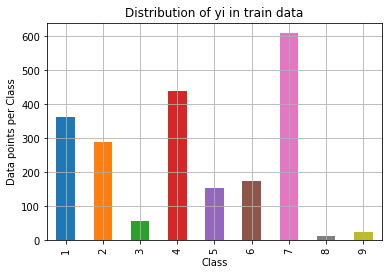

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


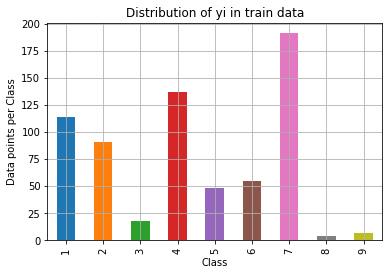

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


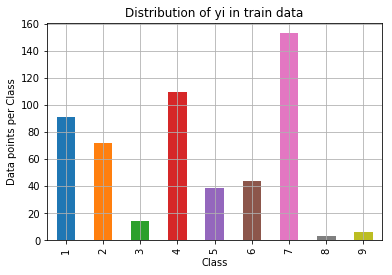

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [106]:
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()


my_colors = 'rgbkymc'

train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
print("=" * 100)


test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')
print("=" * 100)

cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')
print("=" * 100)

<h3> Prediction using a <span style="color:blue">Random</span> Model</h3>

<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. </p>

In [107]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = (C.T / C.sum(axis=1)).T
    
    B = C / C.sum(axis=0)
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print(":"*20, "Confusion matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print(":"*20, "Precision matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print(":"*20, "Recall matrix", ":"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
                

Log loss on Cross Validation Data using Random Model 2.47640907898673
Log loss on Test Validation Data using Random Model 2.4703634454425085
:::::::::::::::::::: Confusion matrix ::::::::::::::::::::


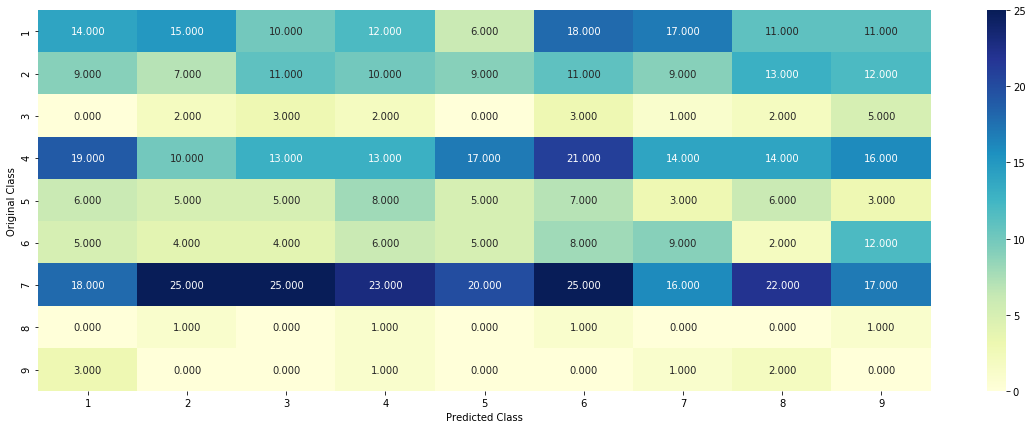

:::::::::::::::::::: Precision matrix ::::::::::::::::::::


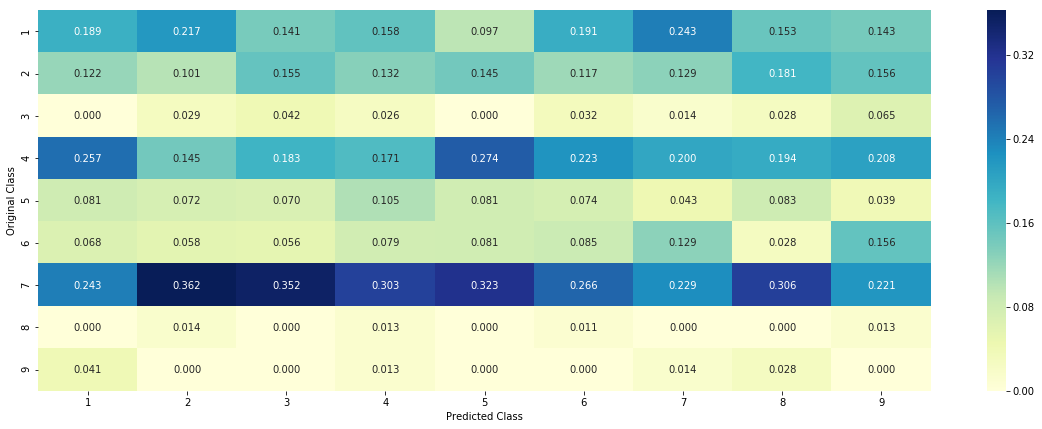

:::::::::::::::::::: Recall matrix ::::::::::::::::::::


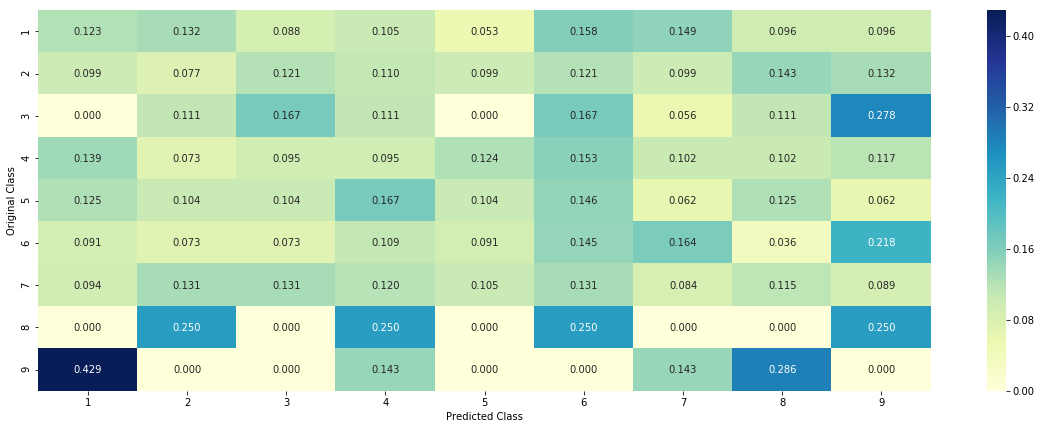

In [108]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len, 9))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 9)
    cv_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv, cv_predicted_y, eps=1e-15))

    
test_predicted_y = np.zeros((test_data_len, 9))

for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    test_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Test Validation Data using Random Model",log_loss(y_test, test_predicted_y, eps=1e-15))


predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)



### Submission

In [114]:
df_variants_test = pd.read_csv(path/'test_variants', names=df_variants.columns)
print(f"Number of data points and features:: {df_variants_test.shape}")
df_variants_test.head()

Number of data points and features:: (368, 4)


,ID,Gene,Variation,Class
0,0,CBL,H398Q,4
1,1,CBL,S80N,6
2,2,SHOC2,M173I,4
3,3,DICER1,D1709N,4
4,4,PTPRT,S492F,1


In [115]:
df_text_test = pd.read_csv(path/'test_text', sep="\|\|", engine="python", names=['ID', 'TEXT'], skiprows=0)
print(f"Number of data points and features:: {df_text_test.shape}")
df_text_test.head()

Number of data points and features:: (368, 2)


,ID,TEXT
0,0,Oncogenic mutations in the monomeric Casitas B...
1,1,Abstract Background Non-small cell lung canc...
2,2,Rasopathies are phenotypically similar syndrom...
3,3,Abstract DICER1 plays a critical role in mic...
4,4,The receptor protein tyrosine phosphatase T (P...


In [116]:
df_final_test = pd.merge(df_variants_test, df_text_test, on='ID', how='left')
df_final_test.shape

(368, 5)

## Helper Functions

In [130]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea
            

<h2> Univariate Analysis</h2>

<h3>1. Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [118]:
unique_genes = train_df.Gene.value_counts()
print(f"Number of unique Genes:: {unique_genes.shape[0]}")
unique_genes.head(10)

Number of unique Genes:: 228


BRCA1     173
TP53      105
EGFR       85
PTEN       82
BRCA2      80
KIT        69
BRAF       56
ERBB2      50
ALK        41
PIK3CA     41
Name: Gene, dtype: int64

In [119]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 228 different categories of genes in the train data, and they are distibuted as follows


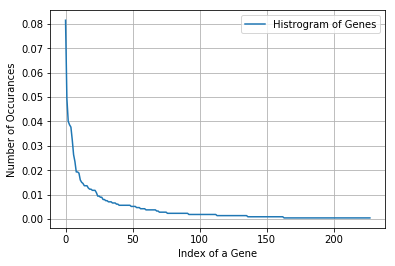

In [127]:
s = np.sum(unique_genes.values)
h = unique_genes.values / s
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


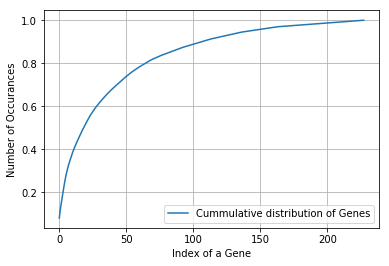

In [128]:
c = np.cumsum(h)
plt.plot(c, label="Cummulative distribution of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [131]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [133]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [134]:
# one-hot encoding of Gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [135]:
train_gene_feature_onehotCoding.shape

(2124, 228)

In [136]:
train_df['Gene'].head()

1912     FOXP1
798      ERBB4
1982    CTNNB1
1194    PIK3CA
725      ERBB2
Name: Gene, dtype: object

In [137]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid5b',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbk

<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.1716160678017016
For values of alpha =  0.0001 The log loss is: 1.1542719928297684
For values of alpha =  0.001 The log loss is: 1.2064541698244815
For values of alpha =  0.01 The log loss is: 1.326671769344707
For values of alpha =  0.1 The log loss is: 1.4358188873253246
For values of alpha =  1 The log loss is: 1.469956109425218


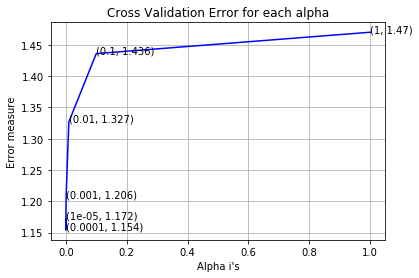

For values of alpha:: 0.0001, the train log loss is:: 0.9974588212297509
For values of alpha:: 0.0001, the cv log loss is:: 1.1542719928297684
For values of alpha:: 0.0001, the test log loss is:: 1.2256169298420392


In [145]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty="l2", loss="log", random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_gene_feature_onehotCoding, y_train)
    predicted_y = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error.append(log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty="l2", loss="log", random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_gene_feature_onehotCoding, y_train)

predicted_y = calib_clf.predict_proba(train_gene_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(y_train, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_gene_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15)}")




<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

<p style="font-size:18px;"> <b> Q6. </b> How many data points in Test and CV datasets are covered by the genes in train dataset?" </p>

In [146]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Ans
1. In test data 638 out of 665 : 95.93984962406014
2. In cross validation data 511 out of  532 : 96.05263157894737


<h3> Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [148]:
unique_variation = train_df['Variation'].value_counts()
print(f"Number of unique variation:: {unique_variation.shape[0]}")
unique_variation.head(10)

Number of unique variation:: 1937


Truncating_Mutations    62
Deletion                42
Amplification           38
Fusions                 22
Overexpression           4
E17K                     3
T58I                     3
Q61R                     2
K117N                    2
R170W                    2
Name: Variation, dtype: int64

In [149]:
print("Ans: There are", unique_variation.shape[0] ,"different categories of variation in the train data, and they are distibuted as follows",)


Ans: There are 1937 different categories of variation in the train data, and they are distibuted as follows


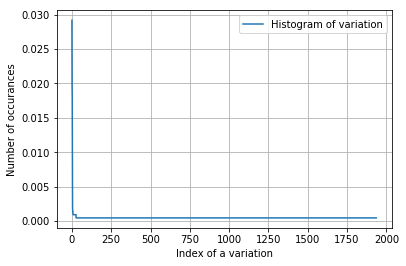

In [151]:
s = np.sum(unique_variation.values)
h = unique_variation.values / s

plt.plot(h, label="Histogram of variation")
plt.xlabel('Index of a variation')
plt.ylabel('Number of occurances')
plt.legend()
plt.grid()
plt.show()

[0.02919021 0.04896422 0.06685499 ... 0.99905838 0.99952919 1.        ]


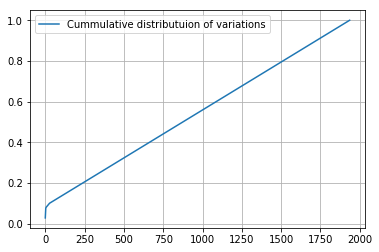

In [153]:
c = np.cumsum(h)
print(c)

plt.plot(c, label="Cummulative distributuion of variations")
plt.legend()
plt.grid()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [154]:
alpha = 1

train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, 'Variation', cv_df))

train_variation_feature_responseCoding.shape, test_variation_feature_responseCoding.shape, cv_variation_feature_responseCoding.shape



((2124, 9), (665, 9), (532, 9))

In [155]:
variation_vectorizer = CountVectorizer()

train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df.Variation)
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df.Variation)
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df.Variation)

train_variation_feature_onehotCoding.shape, test_variation_feature_onehotCoding.shape, cv_variation_feature_onehotCoding.shape


((2124, 1968), (665, 1968), (532, 1968))

In [156]:
variation_vectorizer.get_feature_names()

['17',
 '1_fusion',
 '2010_2471trunc',
 '51',
 '533_534del',
 '560_561inser',
 '596_619splice',
 '6a',
 '963_d1010splice',
 '_baiap2l1_fusion',
 '_deletion',
 '_fusion',
 'a1022e',
 'a1066v',
 'a1099t',
 'a111p',
 'a113_splice',
 'a1170v',
 'a1200v',
 'a120s',
 'a121e',
 'a121p',
 'a121v',
 'a122',
 'a1234t',
 'a126d',
 'a126g',
 'a126s',
 'a134d',
 'a1374v',
 'a1459p',
 'a146t',
 'a146v',
 'a148t',
 'a149p',
 'a1519t',
 'a161s',
 'a161t',
 'a1669s',
 'a1685s',
 'a1708e',
 'a1752p',
 'a1789s',
 'a1789t',
 'a1830t',
 'a1843p',
 'a18d',
 'a197t',
 'a2034v',
 'a205t',
 'a209t',
 'a23e',
 'a246p',
 'a263v',
 'a2643g',
 'a2770t',
 'a290t',
 'a298t',
 'a339v',
 'a349p',
 'a36p',
 'a391e',
 'a39p',
 'a41p',
 'a4419s',
 'a459v',
 'a500t',
 'a502_y503dup',
 'a504_y505ins',
 'a532h',
 'a546d',
 'a57v',
 'a598v',
 'a59t',
 'a627t',
 'a633v',
 'a634d',
 'a634v',
 'a648t',
 'a677g',
 'a723d',
 'a728v',
 'a72s',
 'a72v',
 'a750_e758del',
 'a750_e758delinsp',
 'a750p',
 'a75p',
 'a763_y764insfqea',
 

<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.7061185799308998
For values of alpha =  0.0001 The log loss is: 1.7067070211544948
For values of alpha =  0.001 The log loss is: 1.7102702886145764
For values of alpha =  0.01 The log loss is: 1.7086381040551182
For values of alpha =  0.1 The log loss is: 1.7140404643633735
For values of alpha =  1 The log loss is: 1.7167620374620816


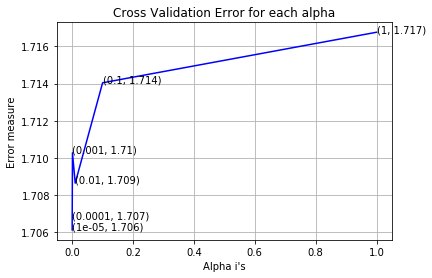

For values of alpha:: 1e-05, the train log loss is:: 0.6975034965783736
For values of alpha:: 1e-05, the cv log loss is:: 1.7061185799308998
For values of alpha:: 1e-05, the test log loss is:: 1.7036504230852156


In [157]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty="l2", loss="log", random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_variation_feature_onehotCoding, y_train)
    predicted_y = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error.append(log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty="l2", loss="log", random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_variation_feature_onehotCoding, y_train)

predicted_y = calib_clf.predict_proba(train_variation_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(y_train, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_variation_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15)}")




<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

<p style="font-size:18px;"> <b> Q6. </b> How many data points in Test and CV datasets are covered by the variation in train dataset?" </p>

In [ ]:
test_coverage= test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage= cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

In [163]:
test_coverage = test_df[test_df.Variation.isin(list(set(train_df.Variation)))].shape[0]
cv_coverage = cv_df[cv_df.Variation.isin(list(set(train_df.Variation)))].shape[0]

print('Ans::')
print(f'In test data:: {test_coverage} out of {test_df.shape[0]} :: {(test_coverage/test_df.shape[0])*100}')
print(f'In test data:: {cv_coverage} out of {cv_df.shape[0]} :: {(cv_coverage/cv_df.shape[0])*100}')


Ans::
In test data:: 68 out of 665 :: 10.225563909774436
In test data:: 66 out of 532 :: 12.406015037593985


<h3> Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [164]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    return dictionary

In [165]:
import math 

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [167]:
dict_list = []
for i in range(1, 10):
    cls_text = train_df[train_df.Class == i]
    dict_list.append(extract_dictionary_paddle(cls_text))
    
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [166]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print(f"Total number of unique words in train data :: {len(train_text_features)}")


Total number of unique words in train data :: 53256


In [168]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [169]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [170]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [171]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [172]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5064, 4: 3759, 6: 2751, 5: 2730, 7: 2490, 8: 2125, 10: 1582, 9: 1582, 12: 1386, 11: 1048, 13: 994, 14: 914, 16: 867, 15: 795, 18: 782, 20: 615, 17: 557, 24: 548, 19: 544, 21: 511, 30: 431, 22: 421, 25: 420, 28: 366, 23: 358, 27: 335, 26: 321, 43: 315, 29: 297, 34: 291, 32: 276, 31: 270, 33: 257, 36: 253, 53: 244, 42: 240, 37: 237, 40: 235, 35: 234, 48: 209, 38: 197, 44: 191, 45: 178, 39: 177, 41: 172, 54: 161, 50: 160, 60: 158, 51: 155, 52: 140, 46: 137, 49: 133, 47: 132, 56: 129, 65: 121, 64: 121, 63: 121, 58: 120, 55: 120, 57: 117, 66: 116, 61: 114, 67: 110, 59: 106, 84: 103, 62: 101, 69: 100, 78: 94, 68: 90, 81: 86, 72: 86, 73: 85, 70: 84, 71: 83, 80: 81, 74: 80, 86: 79, 75: 77, 77: 76, 90: 74, 76: 74, 95: 73, 100: 72, 88: 72, 79: 72, 87: 70, 89: 69, 83: 69, 94: 68, 106: 65, 99: 61, 92: 61, 82: 61, 97: 59, 85: 59, 98: 58, 91: 57, 103: 56, 102: 56, 107: 55, 93: 54, 104: 52, 126: 50, 117: 50, 115: 50, 110: 50, 108: 50, 105: 50, 136: 49, 128: 47, 96: 46, 180: 42, 135: 42, 1

For values of alpha =  1e-05 The log loss is: 1.315419988997579
For values of alpha =  0.0001 The log loss is: 1.216199950386511
For values of alpha =  0.001 The log loss is: 1.2072842750681791
For values of alpha =  0.01 The log loss is: 1.2895575019782577
For values of alpha =  0.1 The log loss is: 1.4828389947579785
For values of alpha =  1 The log loss is: 1.6669999350742208


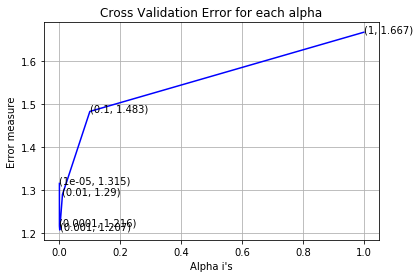

For values of alpha:: 0.001, the train log loss is:: 0.7112753820445042
For values of alpha:: 0.001, the cv log loss is:: 1.2072842750681791
For values of alpha:: 0.001, the test log loss is:: 1.1578505082185546


In [174]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty="l2", loss="log", random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calib_clf.fit(train_text_feature_onehotCoding, y_train)
    predicted_y = calib_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error.append(log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error, c='b')
for i, txt in enumerate(np.round(cv_log_error, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty="l2", loss="log", random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_text_feature_onehotCoding, y_train)

predicted_y = calib_clf.predict_proba(train_text_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the train log loss is:: {log_loss(y_train, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(cv_text_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the cv log loss is:: {log_loss(y_cv, predicted_y, labels=clf.classes_, eps=1e-15)}")
predicted_y = calib_clf.predict_proba(test_text_feature_onehotCoding)
print(f"For values of alpha:: {alpha[best_alpha]}, the test log loss is:: {log_loss(y_test, predicted_y, labels=clf.classes_, eps=1e-15)}")




<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [175]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

95.825 % of word of test data appeared in train data
97.679 % of word of Cross Validation appeared in train data
